While messing around with some bugs in my current code, I stumbled across a rather nice fact: for small $L$, the maximum likelihood optimization problem is tractable without any very fancy machinery -- we can use very standard "gradient descent" or "hill-climbing" methods to solve it. This notebook demonstrates the use of these methods. 

Ultimately, we should still be aiming for the EM algorithm, as this tends to be faster and have better scaling properties. However, the results here suggest that the likelihood function has a nice large basin of attraction, and that the estimators (especially of $\gamma$) are not (too) badly biased. Overall, this is a very encouraging result. 

# Set Initial Condition

In [1]:
from urban_growth.simulator_refactor import *
from urban_growth.estimator_refactor import *
from matplotlib import pyplot as plt
%matplotlib inline

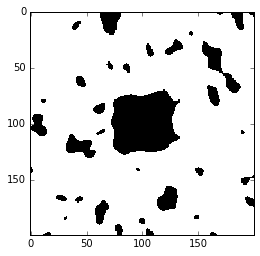

In [2]:
# Initial Configuration
L = 200
rho = .47
blur = 4

# Create the initial matrix and initialize a settlement_model object
M0 = random_mat(L, rho, blur = blur)
m = simulator(M0 = M0)

# Visualize the initial condition
plt.imshow(m.M0, interpolation = 'nearest', cmap = 'Greys')

# Simulate Evolution

In [3]:
# model type
model = 'logistic'

# rural-to-urban threshold
T_vec = [100]

# dynamical parameters
alpha = np.array([9, 9])
beta  = np.array([-9, -11])
gamma = np.array([2.1, 2.5])


In [4]:
M1 = m.dynamics(T_vec = T_vec,
                model = model, 
                n_iters = 1, 
                verbose = True,  
                return_type = 'plain',
                alpha = alpha, 
                beta = beta, 
                gamma = gamma)

urban_growth/helpers.py:157: RuntimeWarning: invalid value encountered in divide
  x = - 1 / (3.0 * a) * (b + C1 + d0 / C1)
urban_growth/helpers.py:162: RuntimeWarning: divide by zero encountered in power
  return 2 * theta * (r_0 ** (2.0 - gamma) - r_1 ** (2.0 - gamma)) / (gamma - 2.0)


Step 1 completed


urban_growth/simulator_refactor.py:16: RuntimeWarning: invalid value encountered in less
  new_mat = (rands < prob) * 1


In [5]:
e = estimator(M0 = M0)
X = M1 - e.get_M0()
X[e.get_M0() == 1] = np.nan

e.partition_clusters(T_vec)
e.distance_variables()

Now let's visualize the data alongside the probability density that generated it. 

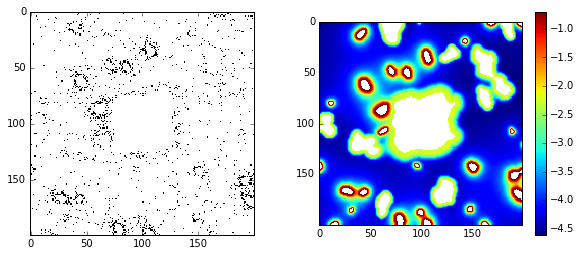

In [ ]:
Y = models[model]['density'](e, alpha = alpha, 
                       beta = beta, 
                       gamma = gamma)

f, axarr = plt.subplots(1, 2, figsize = (10, 4))
im = axarr[1].imshow(np.log(Y), interpolation = 'nearest')
plt.colorbar(im)
axarr[0].imshow(X, interpolation = 'nearest', cmap = 'Greys')

# Direct Maximum Likelihood Estimation

In [ ]:
# initial estimates
alpha_0 = alpha.astype('float') + 10 * (np.random.rand(2) - .5)
beta_0  = beta + 5 * (np.random.rand(2) - .5) 
gamma_0 = 2 + 2 * np.random.rand(2)

pars_0 = {'alpha' : alpha_0,
          'beta'  : beta_0,
          'gamma' : gamma_0}

initial_ll = e.log_likelihood(M1, 
                 model = model, 
                 normalized = True, 
                 **pars_0)

true_ll = e.log_likelihood(M1, 
                 model = model, 
                 normalized = True, 
                 alpha = alpha, 
                 beta = beta, 
                 gamma = gamma)

estimates = e.ML(M1,
                 model = model,
                 pars = pars_0)

alpha_hat = estimates[0]['alpha']
beta_hat  = estimates[0]['beta']
gamma_hat = estimates[0]['gamma']

print true_ll, initial_ll, - estimates[1]

## Covariance matrix

In [ ]:
plt.imshow(estimates[2] / np.nansum(X) , interpolation = 'nearest')
plt.colorbar()

In [ ]:
f, axarr = plt.subplots(1, 3, figsize = (10, 4))
im = axarr[0].imshow(np.log(Y), interpolation = 'nearest', vmin = -5, vmax = -.5)
axarr[0].set_title('True Density')

im = axarr[1].imshow(X, interpolation = 'nearest', cmap = 'Greys')
axarr[1].set_title('Synthetic Data')

Y_hat = models[model]['density'](e, 
                                 alpha = alpha_hat, 
                                 beta = beta_hat, 
                                 gamma = gamma_hat)
im = axarr[2].imshow(np.log(Y_hat), interpolation = 'nearest', vmin = -5, vmax = -.5)
axarr[2].set_title('Learned Density')

Let's take a look at the parameters; true parameters are on the right and estimates ones on the left. 

In [ ]:
print 'alpha: ' + str(np.round(alpha_hat, 2)) +  ' , ' + str(alpha)
print 'beta : ' + str(np.round(beta_hat, 2)) +  ' , ' + str(beta)
print 'gamma: ' + str(np.round(gamma_hat, 2)) +  ' , ' + str(gamma)